Importation des bibliothèques et des méthodes nécessaires 

In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))

In [2]:
import pandas as pd
from preprocessing.text_preprocessing import clean_text
from features.feature_extraction import extract_all_features

Charger dataset kaggle

In [3]:
df = pd.read_csv("../data/raw/Phishing_Email.csv")
print(df.columns)

Index(['Unnamed: 0', 'Email Text', 'Email Type'], dtype='object')


Nettoyage de base

In [4]:
df = df[["Email Text", "Email Type"]].copy()
df.columns = ["text", "label"]
# Supprimer les valeurs manquantes
df.dropna(inplace=True)

# Nettoyage du texte
df["text"] = df["text"].apply(clean_text)

# Supprimer les textes vides après nettoyage
df = df[df["text"].str.len() > 0]

# Supprimer les doublons
df.drop_duplicates(subset=["text"], inplace=True)

df.reset_index(drop=True, inplace=True)
df["label"] = df["label"].map({
    "Safe Email": 0,
    "Phishing Email": 1
})

In [5]:
features_list=[]

In [6]:
for _, row in df.iterrows():
    text = row["text"] 

    email_data = {
        "Body_Text": text,
        "Attachments": [],  
        "Received-SPF": None,
        "DKIM-Signature": None,
        "Authentication-Results": None
    }

    features = extract_all_features(email_data, text)
    features["label"] = row["label"]

    features_list.append(features)

In [7]:
final_df = pd.DataFrame(features_list)

Sauvegarde du Dataset final

In [8]:
final_df.to_csv("../data/processed/emails_features.csv", index=False)

Vérification du nettoyage et préparation 

In [9]:
# Vérifier les valeurs manquantes dans toutes les colonnes
print(final_df.isnull().sum())

text_length              0
word_count               0
suspicious_word_count    0
url_count                0
https_url_count          0
unique_domains           0
spf_present              0
dkim_present             0
dmarc_present            0
attachment_count         0
dangerous_attachment     0
label                    0
dtype: int64


In [10]:
# Nombre de doublons restants
final_df = final_df.drop_duplicates()
print(final_df.duplicated().sum())

0


In [11]:
# Nombre d’emails par label
print(final_df['label'].value_counts())

label
0    9877
1    5832
Name: count, dtype: int64


In [12]:
# Afficher un aperçu des 5 premières lignes
print(final_df.head())

   text_length  word_count  suspicious_word_count  url_count  https_url_count  \
0          919         180                      0          0                0   
1          414          69                      0          0                0   
2         1053         209                      0          0                0   
3          500         107                      0          0                0   
4          387          64                      0          0                0   

   unique_domains  spf_present  dkim_present  dmarc_present  attachment_count  \
0               0            0             0              0                 0   
1               0            0             0              0                 0   
2               0            0             0              0                 0   
3               0            0             0              0                 0   
4               0            0             0              0                 0   

   dangerous_attachment  l

In [13]:
# Résumé statistique des colonnes numériques
print(final_df.describe())

        text_length    word_count  suspicious_word_count  url_count  \
count  1.570900e+04  1.570900e+04           15709.000000    15709.0   
mean   2.611623e+03  4.517058e+02               0.460882        0.0   
std    1.033999e+05  1.750426e+04               8.745668        0.0   
min    3.000000e+00  1.000000e+00               0.000000        0.0   
25%    4.210000e+02  7.600000e+01               0.000000        0.0   
50%    8.670000e+02  1.570000e+02               0.000000        0.0   
75%    1.859000e+03  3.270000e+02               0.000000        0.0   
max    1.295216e+07  2.192680e+06            1080.000000        0.0   

       https_url_count  unique_domains  spf_present  dkim_present  \
count          15709.0         15709.0      15709.0       15709.0   
mean               0.0             0.0          0.0           0.0   
std                0.0             0.0          0.0           0.0   
min                0.0             0.0          0.0           0.0   
25%            

In [14]:
sample = final_df.iloc[0]
print(sample.to_dict())

{'text_length': 919, 'word_count': 180, 'suspicious_word_count': 0, 'url_count': 0, 'https_url_count': 0, 'unique_domains': 0, 'spf_present': 0, 'dkim_present': 0, 'dmarc_present': 0, 'attachment_count': 0, 'dangerous_attachment': 0, 'label': 0}


Step 2 - Développement du Modèle

Importation des bibliothèques

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_auc_score, roc_curve
)
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

1. CHARGEMENT DES DONNÉES

In [16]:
print("📊 Chargement des données...")
df = pd.read_csv("../data/processed/emails_features.csv")

print(f"✅ Dataset chargé : {len(df)} emails")
print(f"📈 Distribution des labels :")
print(df['label'].value_counts())
print()

📊 Chargement des données...
✅ Dataset chargé : 17425 emails
📈 Distribution des labels :
label
0    10960
1     6465
Name: count, dtype: int64



2. DATA CLEANING 

In [17]:
print("🧹 Vérification des données...")
print(f"Valeurs manquantes : {df.isnull().sum().sum()}")
print(f"Doublons : {df.duplicated().sum()}")

# Supprimer les doublons si nécessaire
df = df.drop_duplicates()
df = df.dropna()
print(f"✅ Données nettoyées : {len(df)} emails")
print()

🧹 Vérification des données...
Valeurs manquantes : 0
Doublons : 1716
✅ Données nettoyées : 15709 emails



3. FEATURE SELECTION 

In [18]:
print("🎯 Sélection des features...")

X = df.drop("label", axis=1)
y = df["label"]

# 3.1 Suppression des features à variance nulle
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.0)
X_variance = selector.fit_transform(X)
features_kept = X.columns[selector.get_support()].tolist()

print(f"Features après suppression variance nulle : {len(features_kept)}")
print(f"Features conservées : {features_kept}")
print()

X = X[features_kept]

# 3.2 Analyse d'importance avec Random Forest
print("📊 Analyse d'importance des features...")
rf_temp = RandomForestClassifier(n_estimators=100, random_state=42)
rf_temp.fit(X, y)

importances = pd.Series(rf_temp.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

print("Importance des features :")
print(importances)
print()

# Garder les features avec importance > 0.01
selected_features = importances[importances > 0.01].index.tolist()
print(f"✅ Features sélectionnées : {selected_features}")
print()

# ATTENTION : Si moins de 3 features, garder au moins les 3 meilleures
if len(selected_features) < 3:
    selected_features = importances.nlargest(3).index.tolist()
    print(f"⚠️ Ajustement : gardé les 3 meilleures features")

X_selected = X[selected_features]

🎯 Sélection des features...
Features après suppression variance nulle : 3
Features conservées : ['text_length', 'word_count', 'suspicious_word_count']

📊 Analyse d'importance des features...
Importance des features :
text_length              0.625723
word_count               0.345188
suspicious_word_count    0.029089
dtype: float64

✅ Features sélectionnées : ['text_length', 'word_count', 'suspicious_word_count']



4. TRAIN/TEST SPLIT

In [19]:
print("✂️ Séparation Train/Test...")
X_train, X_test, y_train, y_test = train_test_split(
    X_selected,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Train : {len(X_train)} emails")
print(f"Test : {len(X_test)} emails")
print()

✂️ Séparation Train/Test...
Train : 12567 emails
Test : 3142 emails



5. DATA BALANCING (SMOTE)

In [20]:
print("⚖️ Balancement des classes avec SMOTE...")
print(f"Avant SMOTE : {y_train.value_counts().to_dict()}")

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Après SMOTE : {pd.Series(y_train_resampled).value_counts().to_dict()}")
print()

⚖️ Balancement des classes avec SMOTE...
Avant SMOTE : {0: 7901, 1: 4666}
Après SMOTE : {0: 7901, 1: 7901}



6. STANDARDISATION (important pour DL)

In [21]:
print("🔧 Standardisation des features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

print("✅ Features standardisées")
print()

🔧 Standardisation des features...
✅ Features standardisées



7. MACHINE LEARNING MODELS

In [22]:
print("=" * 70)
print("🤖 MACHINE LEARNING MODELS")
print("=" * 70)

# 7.1 Logistic Regression
print("\n📊 1. LOGISTIC REGRESSION")
print("-" * 70)

model_lr = LogisticRegression(max_iter=1000, random_state=42)
model_lr.fit(X_train_scaled, y_train_resampled)

y_pred_lr = model_lr.predict(X_test_scaled)
y_proba_lr = model_lr.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix :")
print(confusion_matrix(y_test, y_pred_lr))
print("\nClassification Report :")
print(classification_report(y_test, y_pred_lr))
print(f"ROC-AUC Score : {roc_auc_score(y_test, y_proba_lr):.4f}")

# 7.2 Random Forest
print("\n📊 2. RANDOM FOREST")
print("-" * 70)

model_rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    class_weight="balanced"
)
model_rf.fit(X_train_scaled, y_train_resampled)

y_pred_rf = model_rf.predict(X_test_scaled)
y_proba_rf = model_rf.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix :")
print(confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report :")
print(classification_report(y_test, y_pred_rf))
print(f"ROC-AUC Score : {roc_auc_score(y_test, y_proba_rf):.4f}")

🤖 MACHINE LEARNING MODELS

📊 1. LOGISTIC REGRESSION
----------------------------------------------------------------------

Confusion Matrix :
[[1101  875]
 [ 418  748]]

Classification Report :
              precision    recall  f1-score   support

           0       0.72      0.56      0.63      1976
           1       0.46      0.64      0.54      1166

    accuracy                           0.59      3142
   macro avg       0.59      0.60      0.58      3142
weighted avg       0.63      0.59      0.60      3142

ROC-AUC Score : 0.6152

📊 2. RANDOM FOREST
----------------------------------------------------------------------

Confusion Matrix :
[[1274  702]
 [ 439  727]]

Classification Report :
              precision    recall  f1-score   support

           0       0.74      0.64      0.69      1976
           1       0.51      0.62      0.56      1166

    accuracy                           0.64      3142
   macro avg       0.63      0.63      0.63      3142
weighted avg       0

8. DEEP LEARNING MODEL

In [23]:
print("\n" + "=" * 70)
print("🧠 DEEP LEARNING MODEL")
print("=" * 70)

# 8.1 Architecture du réseau
n_features = X_train_scaled.shape[1]

model_dl = Sequential([
    Dense(128, activation='relu', input_shape=(n_features,)),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(32, activation='relu'),
    Dropout(0.2),
    
    Dense(1, activation='sigmoid')
])

# 8.2 Compilation
model_dl.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'AUC']
)

print("\nArchitecture du réseau :")
model_dl.summary()

# 8.3 Entraînement
print("\n🎓 Entraînement du modèle...")

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model_dl.fit(
    X_train_scaled,
    y_train_resampled,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# 8.4 Évaluation
print("\n📊 Évaluation sur le test set...")

y_pred_dl_proba = model_dl.predict(X_test_scaled).flatten()
y_pred_dl = (y_pred_dl_proba > 0.5).astype(int)

print("\nConfusion Matrix :")
print(confusion_matrix(y_test, y_pred_dl))
print("\nClassification Report :")
print(classification_report(y_test, y_pred_dl))
print(f"ROC-AUC Score : {roc_auc_score(y_test, y_pred_dl_proba):.4f}")


🧠 DEEP LEARNING MODEL


C:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Architecture du réseau :


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,649 (45.50 KB)

 Trainable params: 11,265 (44.00 KB)

 Non-trainable params: 384 (1.50 KB)


🎓 Entraînement du modèle...
Epoch 1/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - AUC: 0.5564 - accuracy: 0.5949 - loss: 0.7132 - val_AUC: 0.0000e+00 - val_accuracy: 0.0028 - val_loss: 1.0069
Epoch 2/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.5672 - accuracy: 0.6091 - loss: 0.6738 - val_AUC: 0.0000e+00 - val_accuracy: 0.0035 - val_loss: 1.0164
Epoch 3/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.5836 - accuracy: 0.6177 - loss: 0.6594 - val_AUC: 0.0000e+00 - val_accuracy: 0.0149 - val_loss: 0.9803
Epoch 4/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.5876 - accuracy: 0.6188 - loss: 0.6546 - val_AUC: 0.0000e+00 - val_accuracy: 0.0209 - val_loss: 0.9690
Epoch 5/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.5904 - accuracy: 0.6239 - loss: 0.6532 - val_AUC: 0.0000e+00 - val_accuracy: 0.0187 - val_loss: 0.9909
Epoch 6/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.6018 - accuracy: 0.6245 - loss: 0.6477 - val_AUC: 0.0000e+00 - val_accuracy: 0.0259 - val_

9. VISUALISATIONS


📈 Génération des visualisations...
✅ Visualisations sauvegardées : reports/model_evaluation.png


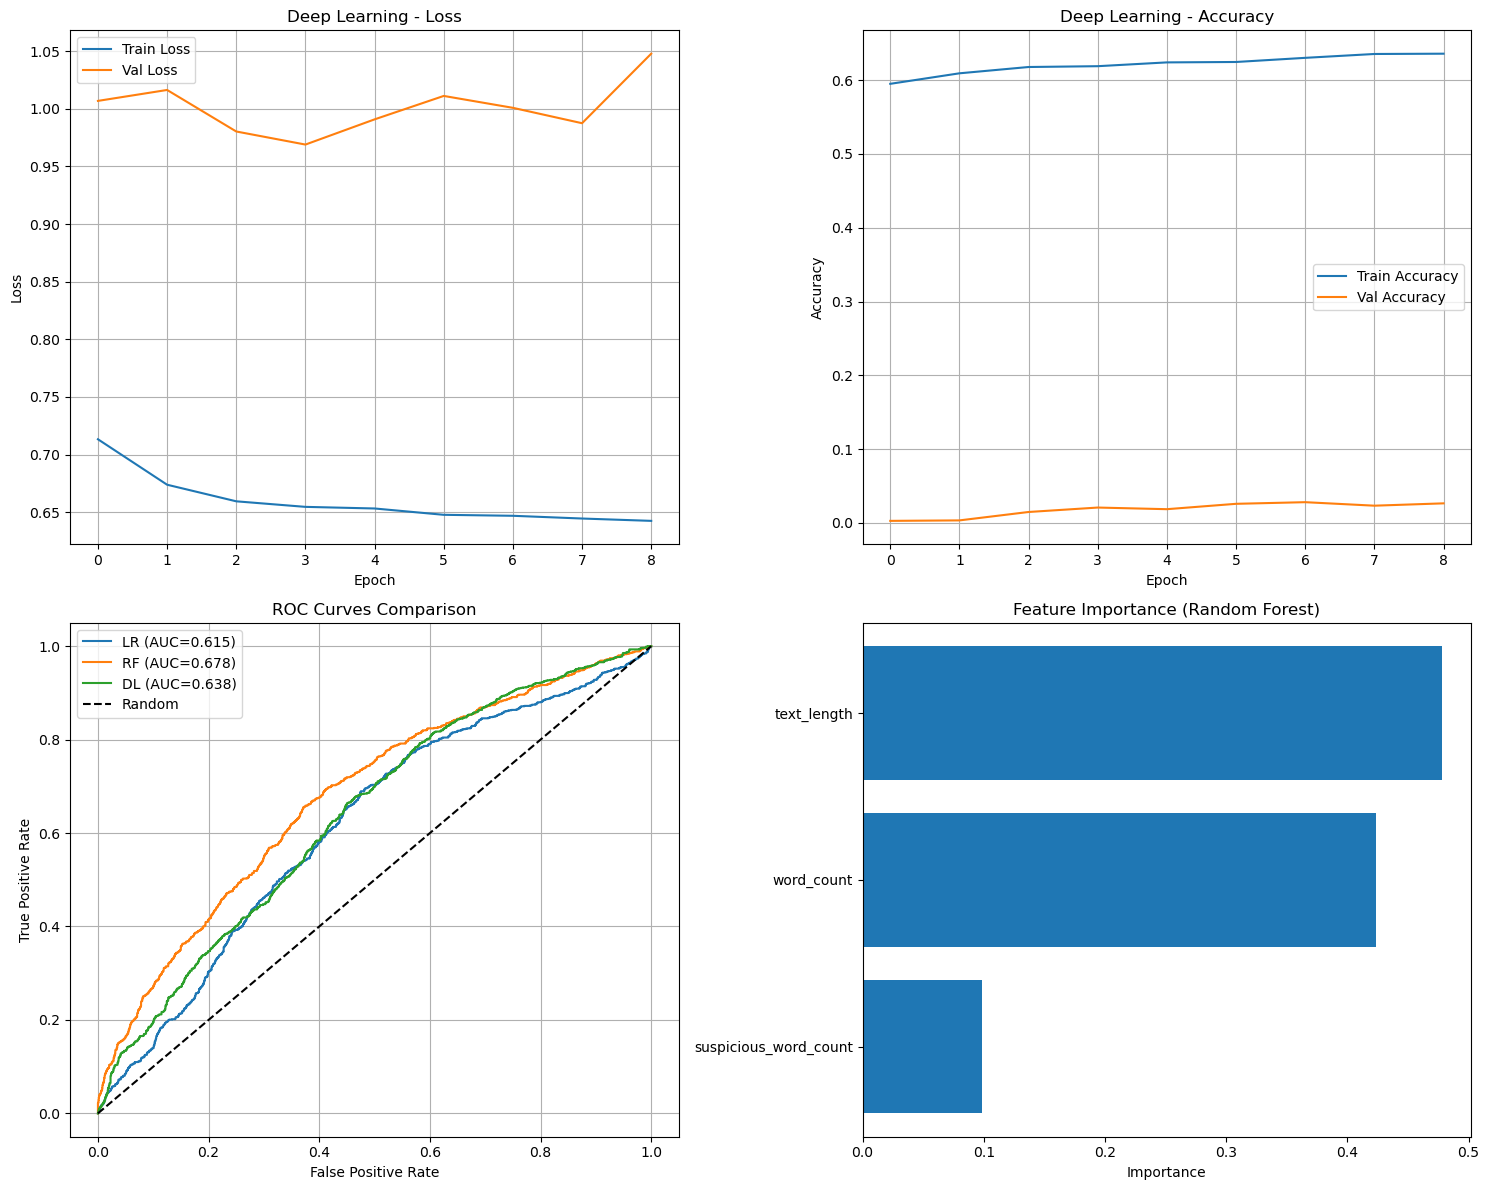

In [25]:
print("\n📈 Génération des visualisations...")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 9.1 Courbes d'entraînement DL
axes[0, 0].plot(history.history['loss'], label='Train Loss')
axes[0, 0].plot(history.history['val_loss'], label='Val Loss')
axes[0, 0].set_title('Deep Learning - Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].plot(history.history['accuracy'], label='Train Accuracy')
axes[0, 1].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[0, 1].set_title('Deep Learning - Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

# 9.2 ROC Curves
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
fpr_dl, tpr_dl, _ = roc_curve(y_test, y_pred_dl_proba)

axes[1, 0].plot(fpr_lr, tpr_lr, label=f'LR (AUC={roc_auc_score(y_test, y_proba_lr):.3f})')
axes[1, 0].plot(fpr_rf, tpr_rf, label=f'RF (AUC={roc_auc_score(y_test, y_proba_rf):.3f})')
axes[1, 0].plot(fpr_dl, tpr_dl, label=f'DL (AUC={roc_auc_score(y_test, y_pred_dl_proba):.3f})')
axes[1, 0].plot([0, 1], [0, 1], 'k--', label='Random')
axes[1, 0].set_title('ROC Curves Comparison')
axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].legend()
axes[1, 0].grid(True)

# 9.3 Feature Importance (RF)
importances_final = pd.Series(model_rf.feature_importances_, index=selected_features)
importances_final = importances_final.sort_values(ascending=True)
axes[1, 1].barh(range(len(importances_final)), importances_final.values)
axes[1, 1].set_yticks(range(len(importances_final)))
axes[1, 1].set_yticklabels(importances_final.index)
axes[1, 1].set_title('Feature Importance (Random Forest)')
axes[1, 1].set_xlabel('Importance')

plt.tight_layout()
plt.savefig('../reports/model_evaluation.png', dpi=300, bbox_inches='tight')
print("✅ Visualisations sauvegardées : reports/model_evaluation.png")

plt.show()

10. SAUVEGARDE DES MODÈLES

In [27]:
print("\n💾 Sauvegarde des modèles...")

import joblib

joblib.dump(model_lr, '../models/logistic_regression.pkl')
joblib.dump(model_rf, '../models/random_forest.pkl')
model_dl.save('../models/deep_learning.h5')
joblib.dump(scaler, '../models/scaler.pkl')
joblib.dump(selected_features, '../models/selected_features.pkl')

print("✅ Modèles sauvegardés avec succès !")


💾 Sauvegarde des modèles...


✅ Modèles sauvegardés avec succès !


11. RÉSUMÉ FINAL

In [28]:
print("\n" + "=" * 70)
print("📊 RÉSUMÉ DES PERFORMANCES")
print("=" * 70)

results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Deep Learning'],
    'ROC-AUC': [
        roc_auc_score(y_test, y_proba_lr),
        roc_auc_score(y_test, y_proba_rf),
        roc_auc_score(y_test, y_pred_dl_proba)
    ]
})

print(results.to_string(index=False))
print("=" * 70)

print("\n✅ Phase 2 terminée avec succès !")
print("📁 Fichiers générés :")
print("   - models/logistic_regression.pkl")
print("   - models/random_forest.pkl")
print("   - models/deep_learning.h5")
print("   - models/scaler.pkl")
print("   - reports/model_evaluation.png")


📊 RÉSUMÉ DES PERFORMANCES
              Model  ROC-AUC
Logistic Regression 0.615189
      Random Forest 0.677901
      Deep Learning 0.637915

✅ Phase 2 terminée avec succès !
📁 Fichiers générés :
   - models/logistic_regression.pkl
   - models/random_forest.pkl
   - models/deep_learning.h5
   - models/scaler.pkl
   - reports/model_evaluation.png
